In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.plot import add_custom_legend

In [3]:
from util_commons import ABSORBERS, PLANETS

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
rcParams["mathtext.default"] = "regular"

In [5]:
# Project
planet = "wasp96b"
path_to_project = Path.home() / "projects" / planet
# Absorbers
absrbrs = [
    "all",
    "h2_h2_cia",
    "h2_he_cia",
    # "li",
    # "na",
    # "k",
    # "rb",
    # "cs",
    "ch4",
    "co",
    "co2",
    "h2o",
    "hcn",
    "nh3",
]

In [6]:
# Load combined resolution UM transmission spectra
path_to_combores = Path.cwd() / "processed" / "transpec_combores"
combores = {}
for exp in ["equilibrium", "kinetics"]:
    combores[exp] = {}
    for mdh in ["mdh0", "mdh1"]:
        combores[exp][mdh] = {}
        for absrbr in tqdm(absrbrs):
            combores[exp][mdh][absrbr] = {}
            for limb in ["full", "morning", "evening"]:
                combores[exp][mdh][absrbr][limb] = {}
                fname_combores = (
                    f"um_{planet}_{exp[0:3]}_{mdh}_transpec_combores_{absrbr}_{limb}.nc"
                )
                cb_combores = iris.load_cube(path_to_combores / fname_combores)
                combores[exp][mdh][absrbr][limb] = cb_combores

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [7]:
def plt_eve_m_mor_contributions(absrbrs, wl_range):
    """Plot combined low and high resolution UM transmission spectra: evening minus morning contributions"""
    plt_absrbrs = absrbrs
    if wl_range == "02_30":
        xmin, xmax = 0.2, 30
        xticks = np.concatenate(
            [
                np.array([0.2, 0.4, 0.6, 0.8]),
                np.array([1, 1.4]),
                np.array([2, 3, 4, 6, 8, 10, 15, 20, 30]),
            ]
        )
    if wl_range == "02_12":
        xmin, xmax = 0.2, 12
        xticks = np.concatenate(
            [
                np.array([0.2, 0.4, 0.6, 0.8]),
                np.array([1, 1.4]),
                np.array([2, 3, 4, 6, 8, 10, 12]),
            ]
        )

    fig, axs = plt.subplots(
        nrows=4, ncols=1, figsize=(10, 12), sharey=True, constrained_layout=True
    )
    for exp, exp_ls, mdh, mdh_lw, ax in zip(
        ["equilibrium", "equilibrium", "kinetics", "kinetics"],
        ["solid", "solid", "solid", "solid"],
        ["mdh0", "mdh1", "mdh0", "mdh1"],
        [1, 1, 1, 1],
        axs,
    ):
        for absrbr in plt_absrbrs:
            plt_morning_combores = combores[exp][mdh][absrbr]["morning"]
            plt_evening_combores = combores[exp][mdh][absrbr]["evening"]
            plt_x_combores = (
                combores[exp][mdh][absrbr]["morning"].coord("spectral_band_centres").points * 1e6
            )  # micrometers
            plt_eve_m_mor = plt_evening_combores - plt_morning_combores
            ax.plot(
                plt_x_combores,
                plt_eve_m_mor.data,
                linestyle=exp_ls,
                linewidth=mdh_lw,
                color=ABSORBERS[absrbr]["color"],
            )
            ax.set_title(f"{exp.capitalize()} [M/H]={mdh[-1]}")
    fig.suptitle(f'{PLANETS[planet]["tex"]} evening minus morning limb difference')
    axs[0].set_title("(a)", loc="left")
    axs[1].set_title("(b)", loc="left")
    axs[2].set_title("(c)", loc="left")
    axs[3].set_title("(d)", loc="left")
    axs[3].set_xlabel("Wavelength [$\mu$m]")
    for ax in axs.flatten():
        ax.set_xscale("log")
        ax.set_xlim(xmin, xmax)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
        ax.axhline(0, ls="dotted", lw=0.75, color="grey")
        ax.set_ylabel("$\Delta(R_p/R_s)^2$ [ppm]")
    # Legends
    absrbr_dict = {
        "All": {"color": ABSORBERS["all"]["color"], "ls": "solid", "lw": 1},
        "$H_2-H_2$ CIA": {"color": ABSORBERS["h2_h2_cia"]["color"], "ls": "solid", "lw": 1},
        "$H_2-He$ CIA": {"color": ABSORBERS["h2_he_cia"]["color"], "ls": "solid", "lw": 1},
        "$CH_4$": {"color": ABSORBERS["ch4"]["color"], "ls": "solid", "lw": 1},
        "$CO$": {"color": ABSORBERS["co"]["color"], "ls": "solid", "lw": 1},
        "$CO_2$": {"color": ABSORBERS["co2"]["color"], "ls": "solid", "lw": 1},
        "$H_2O$": {"color": ABSORBERS["h2o"]["color"], "ls": "solid", "lw": 1},
        "$HCN$": {"color": ABSORBERS["hcn"]["color"], "ls": "solid", "lw": 1},
        "$NH_3$": {"color": ABSORBERS["nh3"]["color"], "ls": "solid", "lw": 1},
    }
    add_custom_legend(
        axs[2],
        absrbr_dict,
        frameon=False,
        alignment="left",
        loc="lower left",
        ncol=3,
        title="Opacity sources:",
    )
    axs[0].legend(frameon=False)
    axs[1].legend(frameon=False)
    axs[2].legend(frameon=False)
    axs[3].legend(frameon=False)
    figname_png = f"{planet}_transpec_wl{wl_range}_combores_eve_m_mor.png"
    figname_pdf = f"{planet}_transpec_wl{wl_range}_combores_eve_m_mor.pdf"
    fig.savefig(path_to_project / "transmission" / figname_png)
    fig.savefig(path_to_project / "transmission" / figname_pdf, format="pdf", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


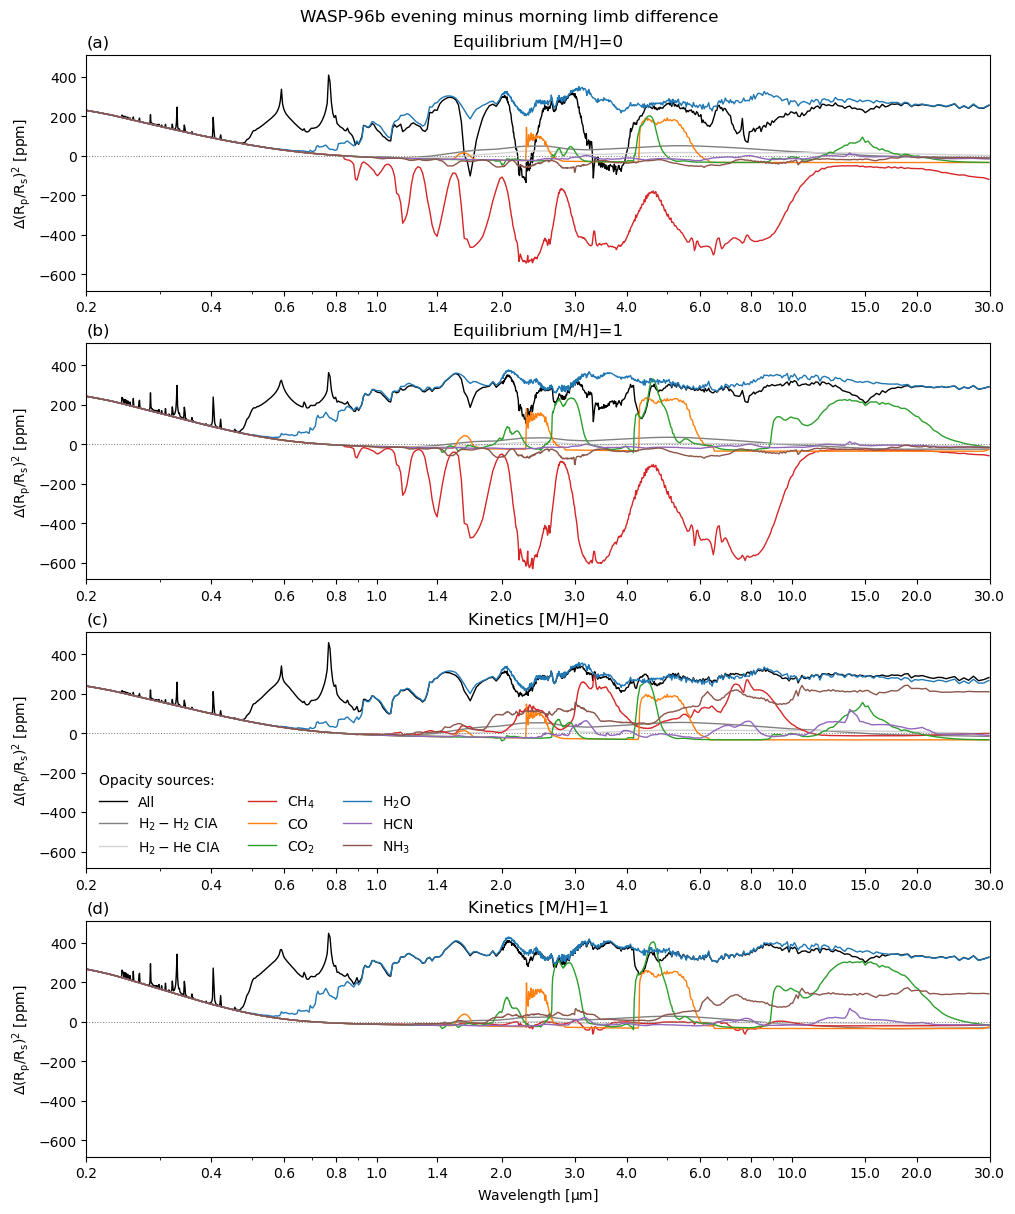

In [8]:
plt_eve_m_mor_contributions(absrbrs, "02_30")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


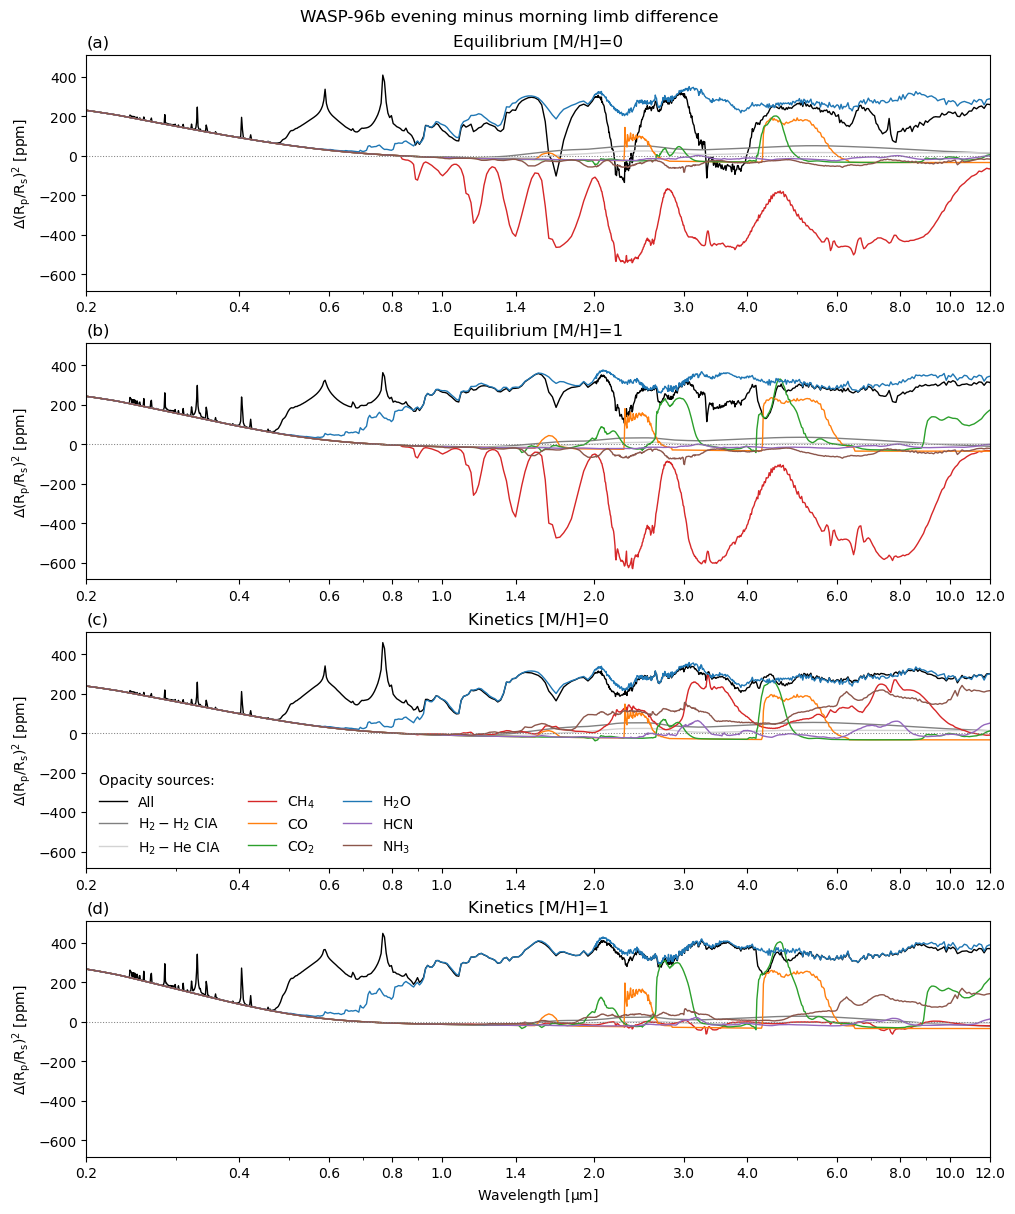

In [9]:
plt_eve_m_mor_contributions(absrbrs, "02_12")